In [ ]:
!pip install keras-tuner -q

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

import tensorflow as tf
from tensorflow import keras as k

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2

from keras.utils import plot_model

from keras import layers
# from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

from keras.callbacks import ModelCheckpoint, CSVLogger


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Set seed
seed_value = 123
random.seed(seed_value) # Set `python` built-in pseudo-random generator

np.random.seed(seed_value) # Set `numpy` random generator at a fixed value

tf.random.set_seed(seed_value) # Set `tensorflow` pseudo-random generator at a fixed value

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# os.chdir('/content/drive/MyDrive/SylviaCapstone/') # DATA_DIR = "/content/drive/MyDrive/SylviaCapstone"
# !ls
os.chdir('/content')

# Load datasets


In [ ]:
from shutil import copy
import random
import collections
from collections import defaultdict

def get_data():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted successfully!")

def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    #print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")



In [ ]:
get_data()
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Dataset already exists
Creating train data...
Copying Done!
Creating test data...
Copying Done!


## Get a mini-set

In [ ]:
from shutil import copytree, rmtree
def dataset_mini(food_list, src, dest):
  if not os.path.exists(dest):
    os.makedirs(dest)   #Make a directory if it does not exists
  for food_item in food_list :
    #print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
food_list = ['apple_pie','cannoli','dumplings', 'miso_soup', 'sushi']
src_train = 'food-101/train'
train_dir = 'food-101/train_mini'
src_test = 'food-101/test'
test_dir = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, train_dir)

print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, test_dir)

Creating train data folder with new classes
Creating test data folder with new classes


### Split Train/Validation Set

In [ ]:
def create_validation_set(src_train, dest_val, split_ratio=0.2):
    # Make a directory for the validation set if it does not exist
    if not os.path.exists(dest_val):
        os.makedirs(dest_val)

    for food_item in food_list:
        src_food_item = os.path.join(src_train, food_item)
        dest_food_item = os.path.join(dest_val, food_item)

        if not os.path.exists(dest_food_item):
            os.makedirs(dest_food_item)

        # List all image files in the source food category
        image_files = os.listdir(src_food_item)

        # Calculate the number of images to move to the validation set
        num_images_to_move = int(len(image_files) * split_ratio)

        # Randomly select images to move
        images_to_move = random.sample(image_files, num_images_to_move)

        # Move the selected images to the validation set directory
        for image in images_to_move:
            src_image = os.path.join(src_food_item, image)
            dest_image = os.path.join(dest_food_item, image)
            os.rename(src_image, dest_image)

# Define the path for the validation set
val_dir = 'food-101/validation_mini'

# Split a portion of the training data into the validation set
create_validation_set(train_dir, val_dir, split_ratio=0.2)


In [ ]:
# !rm -rf food-101/val_mini

# Pre-processing

In [ ]:
N_CLASS = 5
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

print("Training images:")
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)
print("Validating images:")
validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True)

print("Testing images:")
test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True)

Training images:
Found 3000 images belonging to 5 classes.
Validating images:
Found 750 images belonging to 5 classes.
Testing images:
Found 1250 images belonging to 5 classes.


# Model Training


## Test VGG16 with best hyperparameter combination (from w6)

Last week (W6) - {'num_layers': 2, 'units': 2048, 'dropout_rate': 0.2}

In [ ]:
#Callback for model savingand early stopping for preventing overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/SylviaCapstone/w7_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

callbacks_list = [tl_checkpoint_1,stop_early]

# callbacks_list = [tf.keras.callbacks.ModelCheckpoint(
#         filepath = 'Checkpoints',
#         monitor = 'val_loss',
#         save_best_only = True,
#         save_weights_only=True), stop_early]

### VGG16 as feature extraction

In [ ]:
# Train the best architecture model for 15 epochs
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(2048, activation='relu') (x)
x = layers.Dense(2048, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = SGD(lr=0.001, momentum=0.9)

model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = callbacks_list)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.4507
Epoch 1: val_loss improved from inf to 1.03947, saving model to w7_model_v1.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 64s 539ms/step - loss: 1.3383 - accuracy: 0.4507 - val_loss: 1.0395 - val_accuracy: 0.5987
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 1.0654 - accuracy: 0.5870
Epoch 2: val_loss improved from 1.03947 to 0.86950, saving model to w7_model_v1.weights.best.hdf5
94/94 [==============================] - 47s 493ms/step - loss: 1.0654 - accuracy: 0.5870 - val_loss: 0.8695 - val_accuracy: 0.6720
Epoch 3/15
94/94 [==============================] - ETA: 0s - loss: 0.9862 - accuracy: 0.6247
Epoch 3: val_loss did not improve from 0.86950
94/94 [==============================] - 47s 495ms/step - loss: 0.9862 - accuracy: 0.6247 - val_loss: 0.8779 - val_accuracy: 0.6760
Epoch 4/15
94/94 [==============================] - ETA: 0s - loss: 0.9195 - accuracy: 0.6553
Epoch 4: val_loss improved from 0.86950 to 0.84741, saving model to w7_model_v1.weights.best.hdf5
94/94 [==============================] - 47s 505ms/step - loss: 0.9195 - accura

#### Plot training process

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

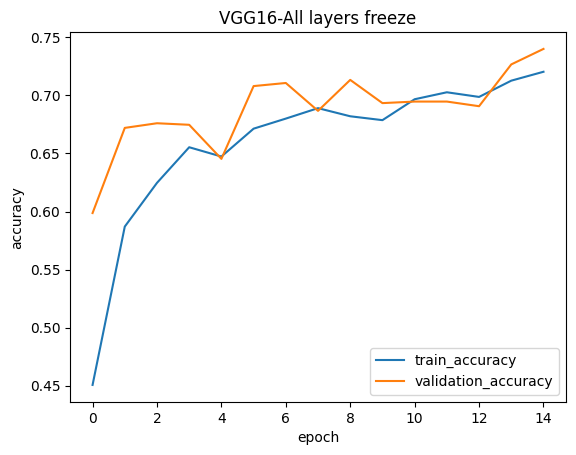

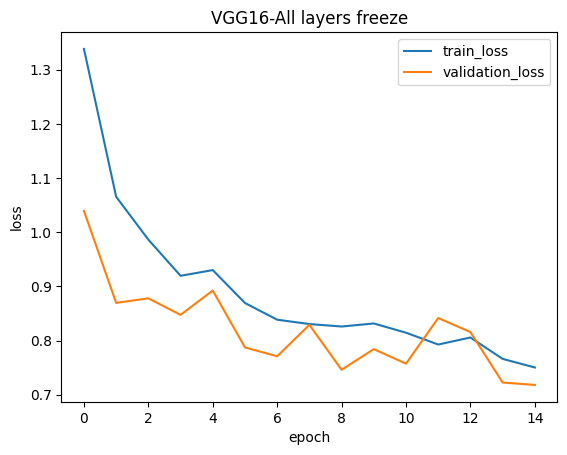

In [ ]:
plot_accuracy(history,'VGG16-All layers freeze')
plot_loss(history,'VGG16-All layers freeze')

#### Test Optimiser

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(2048, activation='relu') (x)
x = layers.Dense(2048, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model_adam = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = Adam(lr=0.001)

model_adam .compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_adam = model_adam.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = callbacks_list)

Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 1.1960 - accuracy: 0.5477
Epoch 1: val_loss did not improve from 0.66970
94/94 [==============================] - 53s 539ms/step - loss: 1.1960 - accuracy: 0.5477 - val_loss: 0.7754 - val_accuracy: 0.7000
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 0.8042 - accuracy: 0.7010
Epoch 2: val_loss did not improve from 0.66970
94/94 [==============================] - 52s 549ms/step - loss: 0.8042 - accuracy: 0.7010 - val_loss: 0.7250 - val_accuracy: 0.7280
Epoch 3/15
94/94 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.7383
Epoch 3: val_loss did not improve from 0.66970
94/94 [==============================] - 52s 550ms/step - loss: 0.7087 - accuracy: 0.7383 - val_loss: 0.6884 - val_accuracy: 0.7467
Epoch 4/15
94/94 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.7470
Epoch 4: val_loss improved from 0.66970 to 0.62393, saving model to w7_model_v1.weights

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 50s 530ms/step - loss: 0.6895 - accuracy: 0.7470 - val_loss: 0.6239 - val_accuracy: 0.7667
Epoch 5/15
94/94 [==============================] - ETA: 0s - loss: 0.6434 - accuracy: 0.7657
Epoch 5: val_loss improved from 0.62393 to 0.60298, saving model to w7_model_v1.weights.best.hdf5
94/94 [==============================] - 52s 551ms/step - loss: 0.6434 - accuracy: 0.7657 - val_loss: 0.6030 - val_accuracy: 0.7747
Epoch 6/15
94/94 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.7687
Epoch 6: val_loss did not improve from 0.60298
94/94 [==============================] - 50s 528ms/step - loss: 0.6365 - accuracy: 0.7687 - val_loss: 0.6497 - val_accuracy: 0.7600
Epoch 7/15
94/94 [==============================] - ETA: 0s - loss: 0.6123 - accuracy: 0.7763
Epoch 7: val_loss did not improve from 0.60298
94/94 [==============================] - 51s 538ms/step - loss: 0.6123 - accuracy: 0.7763 - val_loss: 0.6333 - val_accuracy: 0.772

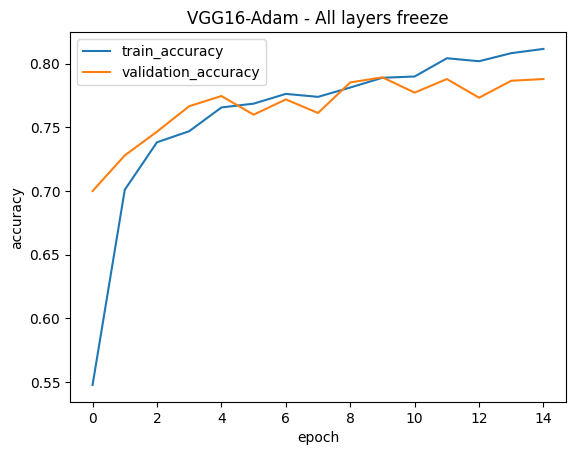

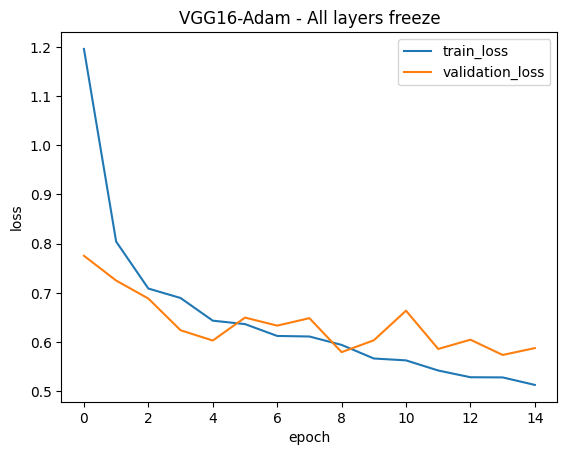

In [ ]:
plot_accuracy(history_adam,'VGG16-Adam - All layers freeze')
plot_loss(history_adam,'VGG16-Adam - All layers freeze')

### Test VGG16 with best hyperparameter combination (optuna result)

{'num_layers': 3, 'dropout_rate': 0.2, 'units_0': 1792, 'units_1': 1792, 'units_2': 1536}.

SGD Optimiser

In [ ]:
#Callback for model savingand early stopping for preventing overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath='w7_model_optuna_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# callbacks_list  = [tl_checkpoint_2,stop_early]


In [ ]:
# Train the best architecture model for 15 epochs
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(1792, activation='relu') (x)
x = layers.Dense(1792, activation='relu') (x)
x = layers.Dense(1536, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = SGD(lr=0.001, momentum=0.9)

model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = [tl_checkpoint_2,stop_early])

Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 1.3548 - accuracy: 0.4410
Epoch 1: val_loss did not improve from 0.71808
94/94 [==============================] - 53s 548ms/step - loss: 1.3548 - accuracy: 0.4410 - val_loss: 0.9885 - val_accuracy: 0.6173
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 1.1197 - accuracy: 0.5503
Epoch 2: val_loss did not improve from 0.71808
94/94 [==============================] - 50s 531ms/step - loss: 1.1197 - accuracy: 0.5503 - val_loss: 1.2232 - val_accuracy: 0.5107
Epoch 3/15
94/94 [==============================] - ETA: 0s - loss: 1.0428 - accuracy: 0.5860
Epoch 3: val_loss did not improve from 0.71808
94/94 [==============================] - 50s 531ms/step - loss: 1.0428 - accuracy: 0.5860 - val_loss: 0.9256 - val_accuracy: 0.6387
Epoch 4/15
94/94 [==============================] - ETA: 0s - loss: 0.9280 - accuracy: 0.6457
Epoch 4: val_loss did not improve from 0.71808
94/94 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 60s 629ms/step - loss: 0.7731 - accuracy: 0.7093 - val_loss: 0.6854 - val_accuracy: 0.7253
Epoch 14/15
94/94 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.6880
Epoch 14: val_loss did not improve from 0.68536
94/94 [==============================] - 59s 630ms/step - loss: 0.7948 - accuracy: 0.6880 - val_loss: 0.7003 - val_accuracy: 0.7373
Epoch 15/15
94/94 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.7173
Epoch 15: val_loss improved from 0.68536 to 0.66970, saving model to w7_model_v1.weights.best.hdf5
94/94 [==============================] - 56s 595ms/step - loss: 0.7349 - accuracy: 0.7173 - val_loss: 0.6697 - val_accuracy: 0.7400


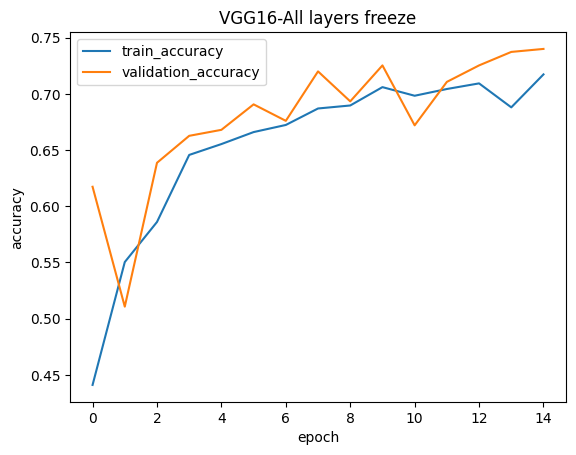

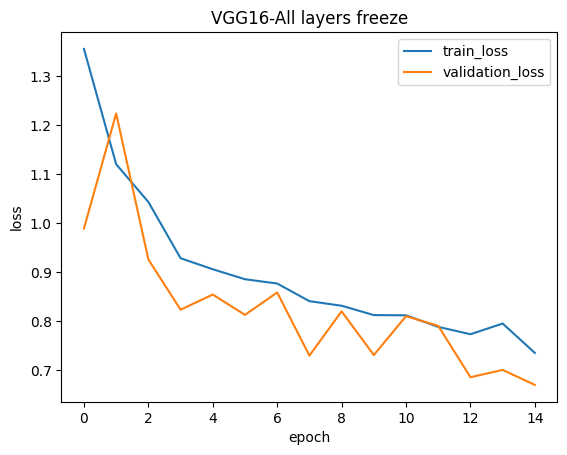

In [ ]:
plot_accuracy(history,'VGG16-All layers freeze')
plot_loss(history,'VGG16-All layers freeze')

Adam Optimiser:

In [ ]:
# Train the best architecture model for 15 epochs
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(1792, activation='relu') (x)
x = layers.Dense(1792, activation='relu') (x)
x = layers.Dense(1536, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model_adam_2 = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = Adam(lr=0.001)

model_adam_2.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_adam_2 = model_adam_2.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = [tl_checkpoint_2,stop_early])

Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 1.1772 - accuracy: 0.5073
Epoch 1: val_loss improved from inf to 0.86864, saving model to w7_model_optuna_v1.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 54s 525ms/step - loss: 1.1772 - accuracy: 0.5073 - val_loss: 0.8686 - val_accuracy: 0.6600
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 0.8471 - accuracy: 0.6780
Epoch 2: val_loss did not improve from 0.86864
94/94 [==============================] - 49s 518ms/step - loss: 0.8471 - accuracy: 0.6780 - val_loss: 0.9057 - val_accuracy: 0.6773
Epoch 3/15
94/94 [==============================] - ETA: 0s - loss: 0.7413 - accuracy: 0.7297
Epoch 3: val_loss improved from 0.86864 to 0.71719, saving model to w7_model_optuna_v1.weights.best.hdf5
94/94 [==============================] - 49s 518ms/step - loss: 0.7413 - accuracy: 0.7297 - val_loss: 0.7172 - val_accuracy: 0.7293
Epoch 4/15
94/94 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.7383
Epoch 4: val_loss improved from 0.71719 to 0.67021, saving model to w7_model_optuna_v1.weights.best.hdf5
94/94 [==============================] - 49s 522ms/step - loss: 0

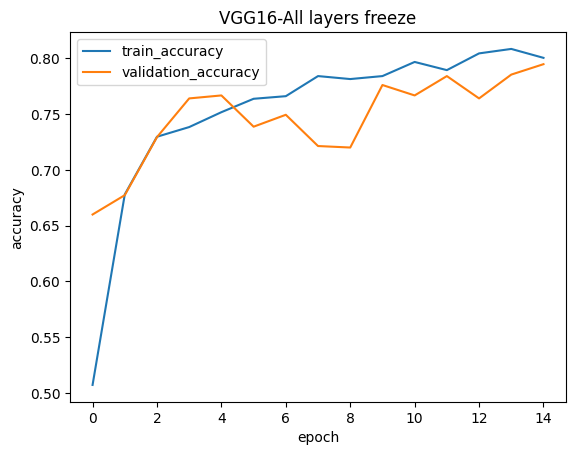

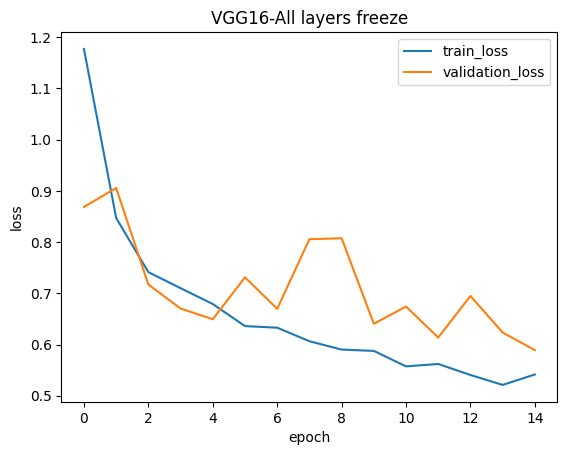

In [ ]:
plot_accuracy(history_adam_2,'VGG16-All layers freeze')
plot_loss(history_adam_2,'VGG16-All layers freeze')

### Fine-tuning

Unfreeze the last 2 layers

In [ ]:
#Callback for model savingand early stopping for preventing overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# ModelCheckpoint callback - save best weights
tuned_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/SylviaCapstone/w7_model_tuned1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

callbacks_list_1 = [tuned_checkpoint_1,stop_early]

Sylvia's best model

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers[:-2]:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(2048, activation='relu') (x)
x = layers.Dense(2048, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model_f4_1 = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = Adam(lr=0.001)

model_f4_1.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

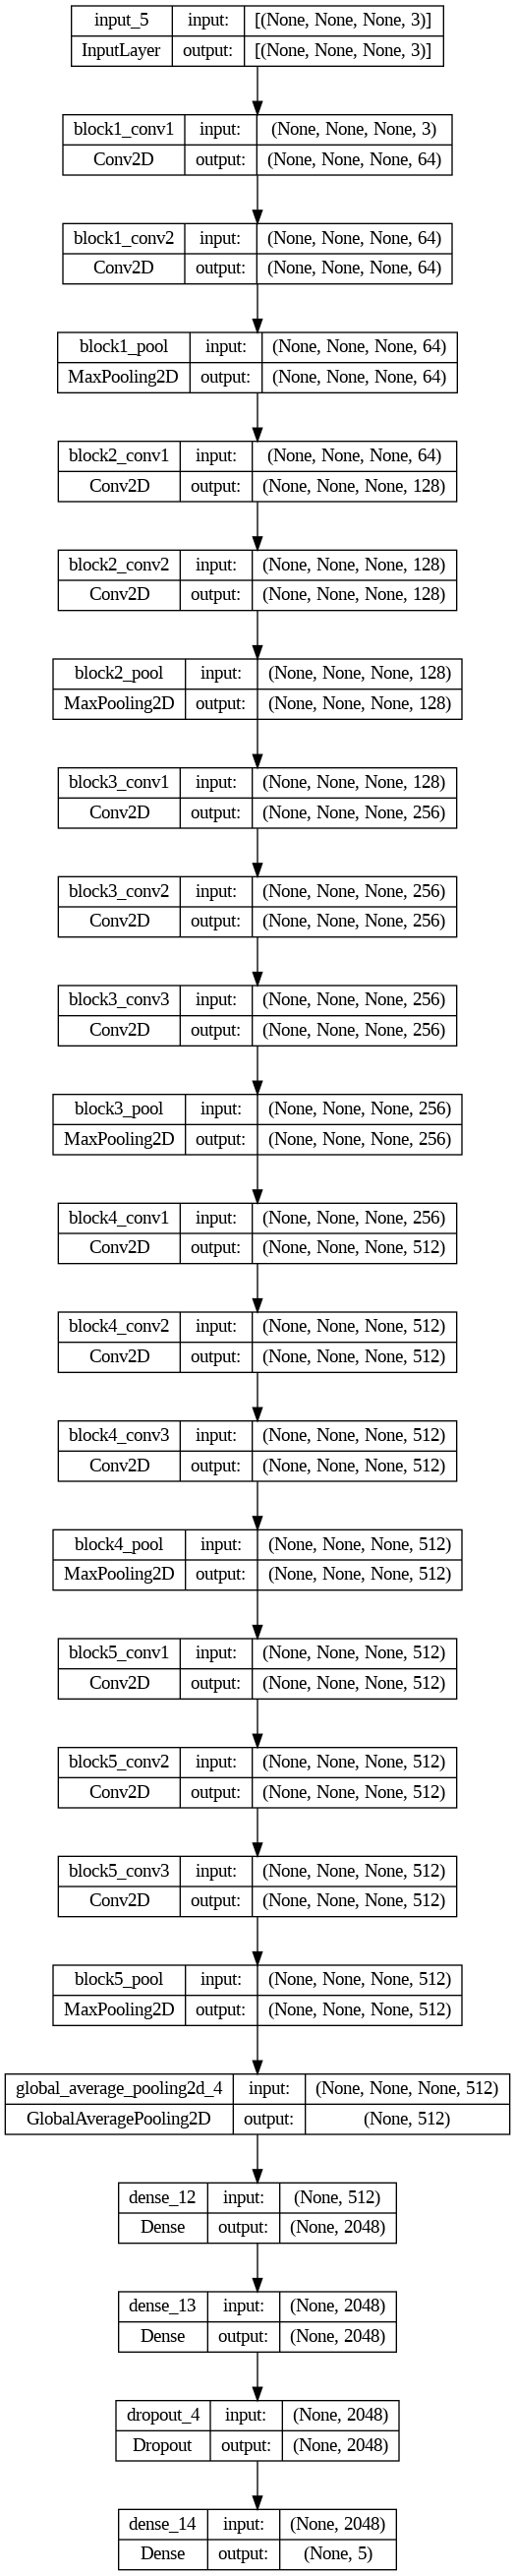

In [ ]:
plot_model(model_f4_1, show_shapes=True, show_layer_names=True)

In [ ]:
model_f4_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
history_f4_1 = model_f4_1.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = callbacks_list_1)

Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.6033
Epoch 1: val_loss improved from inf to 0.66634, saving model to w7_model_tuned1.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 56s 548ms/step - loss: 1.0623 - accuracy: 0.6033 - val_loss: 0.6663 - val_accuracy: 0.7640
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.7553
Epoch 2: val_loss improved from 0.66634 to 0.62879, saving model to w7_model_tuned1.weights.best.hdf5
94/94 [==============================] - 52s 547ms/step - loss: 0.6786 - accuracy: 0.7553 - val_loss: 0.6288 - val_accuracy: 0.7973
Epoch 3/15
94/94 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.7980
Epoch 3: val_loss improved from 0.62879 to 0.52497, saving model to w7_model_tuned1.weights.best.hdf5
94/94 [==============================] - 50s 537ms/step - loss: 0.5888 - accuracy: 0.7980 - val_loss: 0.5250 - val_accuracy: 0.8240
Epoch 4/15
94/94 [==============================] - ETA: 0s - loss: 0.5422 - accuracy: 0.8140
Epoch 4: val_loss did not improve from 0.52497
94/94 [==============================] - 52s 555ms/step - loss: 0.5422 

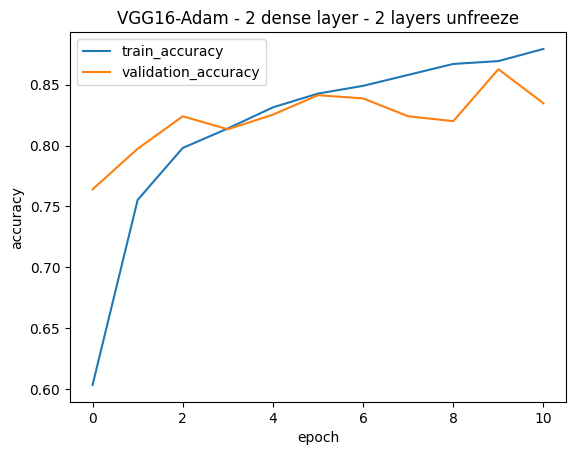

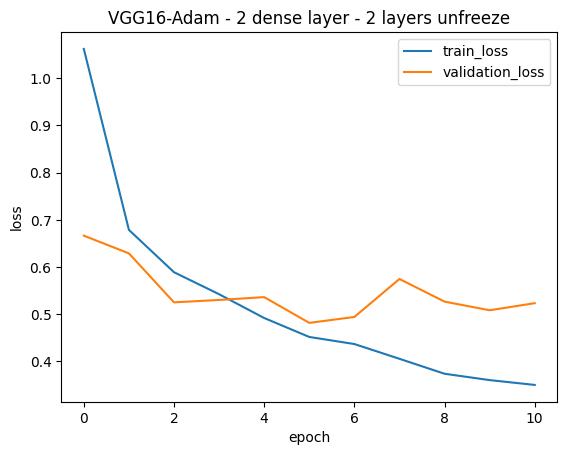

In [ ]:
plot_accuracy(history_f4_1,'VGG16-Adam - 2 dense layer - 2 layers unfreeze')
plot_loss(history_f4_1,'VGG16-Adam - 2 dense layer - 2 layers unfreeze')

Winnie's best model

In [ ]:
# ModelCheckpoint callback - save best weights
tuned_checkpoint_2 = ModelCheckpoint(filepath='/content/drive/MyDrive/SylviaCapstone/w7_model_tuned2.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# callbacks_list_2 = [tuned_checkpoint_2,stop_early]

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers[:-2]:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(1792, activation='relu') (x)
x = layers.Dense(1792, activation='relu') (x)
x = layers.Dense(1536, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model_f4_2 = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = Adam(lr=0.001)

model_f4_2.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_f4_2 = model_f4_2.fit(train_generator,
               validation_data=validation_generator,
               epochs=15,  # Train for more epochs
               verbose=1,
               callbacks = [tuned_checkpoint_2,stop_early])

Epoch 1/15
94/94 [==============================] - ETA: 0s - loss: 1.1465 - accuracy: 0.5480
Epoch 1: val_loss improved from inf to 0.81217, saving model to w7_model_tuned2.weights.best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 55s 537ms/step - loss: 1.1465 - accuracy: 0.5480 - val_loss: 0.8122 - val_accuracy: 0.6813
Epoch 2/15
94/94 [==============================] - ETA: 0s - loss: 0.7330 - accuracy: 0.7450
Epoch 2: val_loss improved from 0.81217 to 0.64618, saving model to w7_model_tuned2.weights.best.hdf5
94/94 [==============================] - 53s 567ms/step - loss: 0.7330 - accuracy: 0.7450 - val_loss: 0.6462 - val_accuracy: 0.7733
Epoch 3/15
94/94 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.7870
Epoch 3: val_loss improved from 0.64618 to 0.60272, saving model to w7_model_tuned2.weights.best.hdf5
94/94 [==============================] - 58s 616ms/step - loss: 0.6063 - accuracy: 0.7870 - val_loss: 0.6027 - val_accuracy: 0.8067
Epoch 4/15
94/94 [==============================] - ETA: 0s - loss: 0.5730 - accuracy: 0.8000
Epoch 4: val_loss did not improve from 0.60272
94/94 [==============================] - 50s 527ms/step - loss: 0.5730 

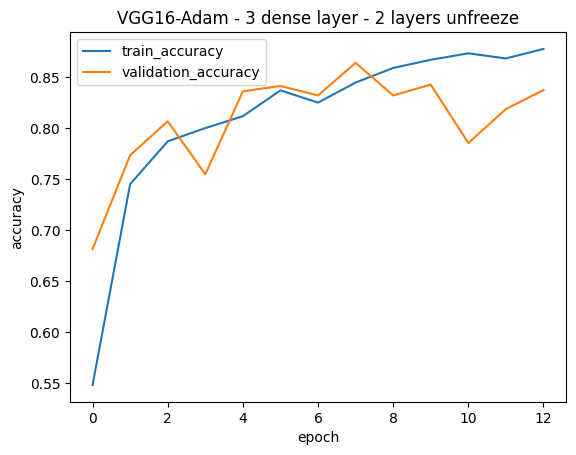

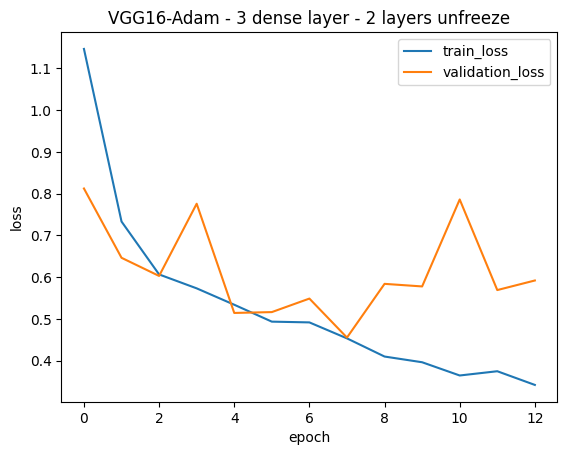

In [ ]:
plot_accuracy(history_f4_2,'VGG16-Adam - 3 dense layer - 2 layers unfreeze')
plot_loss(history_f4_2,'VGG16-Adam - 3 dense layer - 2 layers unfreeze')

Unfreeze last 4 layers

In [ ]:
#Callback for model savingand early stopping for preventing overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# ModelCheckpoint callback - save best weights
tuned_checkpoint_3 = ModelCheckpoint(filepath='/content/drive/MyDrive/SylviaCapstone/w7_model_tuned3.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)


In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False)

for layer in vgg16.layers[:-4]:
    layer.trainable = False

x = vgg16.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(2048, activation='relu') (x)
x = layers.Dense(2048, activation='relu') (x)
x = layers.Dropout(0.2)(x)

predictions = layers.Dense(N_CLASS, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model_f4_3 = k.Model(inputs=vgg16.input, outputs=predictions)

optimizer = Adam(lr=0.001)

model_f4_3.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

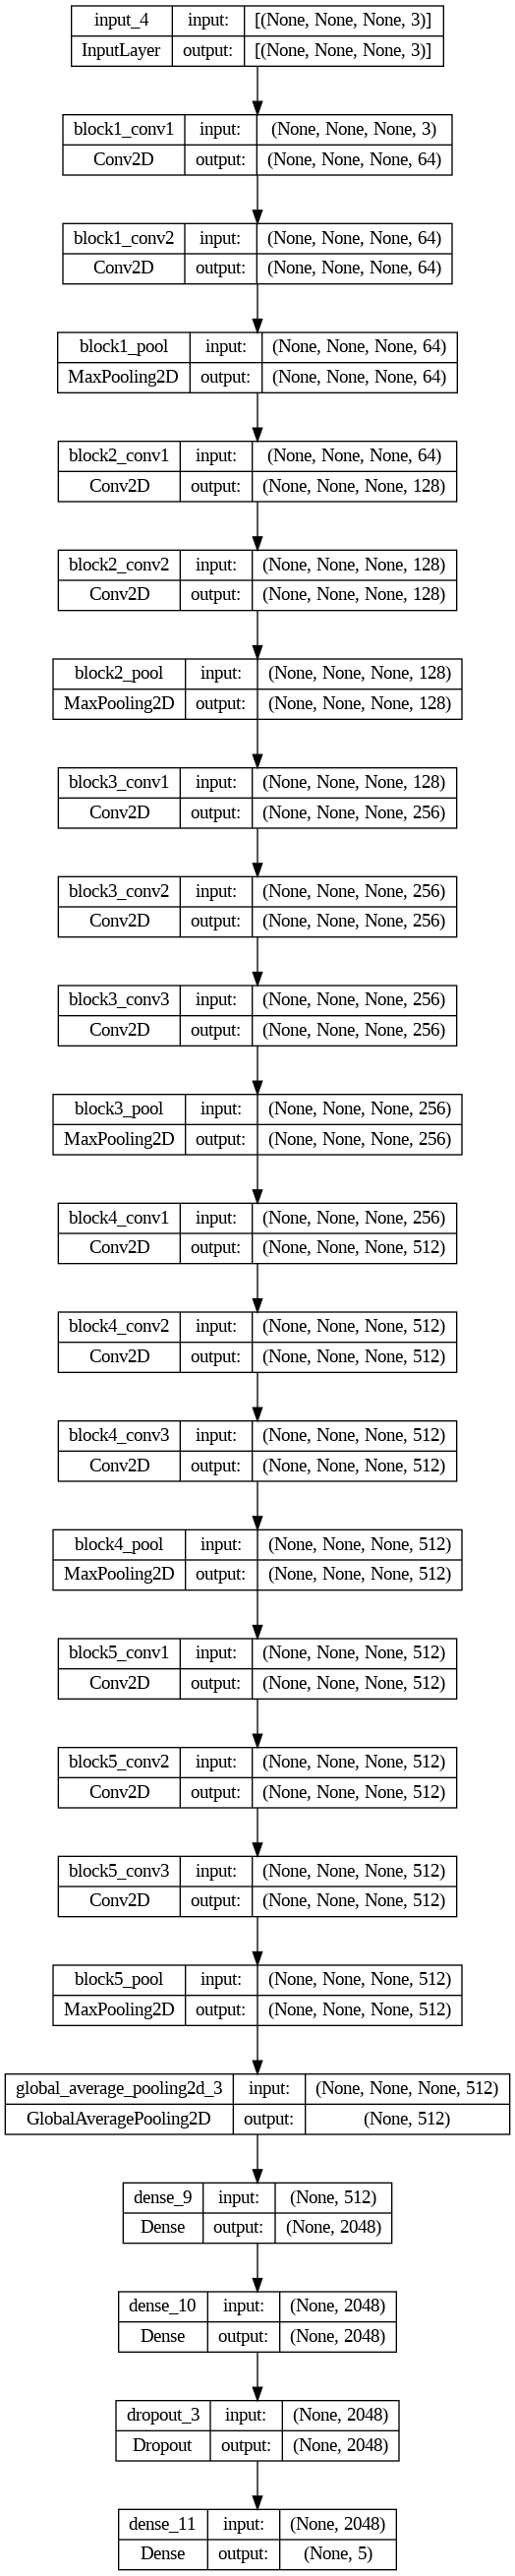

In [ ]:
plot_model(model_f4_3, show_shapes=True, show_layer_names=True)

In [ ]:
model_f4_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
history_f4_3 = model_f4_3.fit(train_generator,
               validation_data=validation_generator,
               epochs=20,  # Train for more epochs
               verbose=1,
               callbacks = [tuned_checkpoint_3,stop_early])

Epoch 1/20
94/94 [==============================] - ETA: 0s - loss: 1.7194 - accuracy: 0.2013
Epoch 1: val_loss did not improve from 0.64371
94/94 [==============================] - 60s 555ms/step - loss: 1.7194 - accuracy: 0.2013 - val_loss: 1.6341 - val_accuracy: 0.2000
Epoch 2/20
94/94 [==============================] - ETA: 0s - loss: 1.6309 - accuracy: 0.1850
Epoch 2: val_loss did not improve from 0.64371
94/94 [==============================] - 54s 578ms/step - loss: 1.6309 - accuracy: 0.1850 - val_loss: 1.6276 - val_accuracy: 0.2000
Epoch 3/20
94/94 [==============================] - ETA: 0s - loss: 1.6257 - accuracy: 0.1893
Epoch 3: val_loss did not improve from 0.64371
94/94 [==============================] - 55s 581ms/step - loss: 1.6257 - accuracy: 0.1893 - val_loss: 1.6234 - val_accuracy: 0.2000
Epoch 4/20
94/94 [==============================] - ETA: 0s - loss: 1.6219 - accuracy: 0.1903
Epoch 4: val_loss did not improve from 0.64371
94/94 [==============================] -

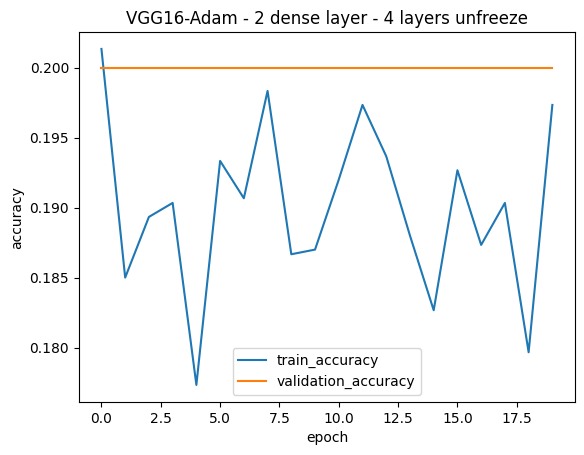

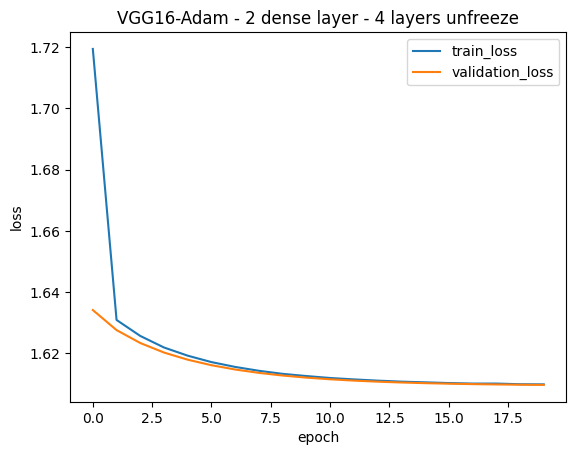

In [ ]:
plot_accuracy(history_f4_3,'VGG16-Adam - 2 dense layer - 4 layers unfreeze')
plot_loss(history_f4_3,'VGG16-Adam - 2 dense layer - 4 layers unfreeze')

## Evaluation

On test data

In [ ]:
# Mapping food categories to their file index
mapping={} # mapping class with its file index
for i,j in enumerate(os.listdir(test_dir)):
    mapping[j]=i
print(mapping)

{'dumplings': 0, 'sushi': 1, 'apple_pie': 2, 'cannoli': 3, 'miso_soup': 4}


In [ ]:
# Prepare true labels and predictions for each class
true_labels=[]
predictions=[]
for i in os.listdir(test_dir):

      filepath = os.path.join(test_dir,i)
      true_class = filepath.split('/')[-1] # cateogry name/label
      true_class = mapping[true_class]
      print(true_class)
      for j in os.listdir(os.path.join(test_dir,i)):
        true_labels.append(true_class)

y_pred_1 = model_f4_1.predict(test_generator)
predictions_1 = np.argmax(y_pred_1, axis=1) # select the class with highest score

y_pred_2 = model_f4_2.predict(test_generator)
predictions_2 = np.argmax(y_pred_2, axis=1) # select the class with highest score

0
1
2
3
4
40/40 [==============================] - 6s 140ms/step


Accuracy of model on test data:

In [ ]:
scores_f4_1 = model_f4_1.evaluate(test_generator)
print("Test Accuracy of tuned model 1(w6): {:.3f}".format(scores_f4_1[1]))

scores_f4_2 = model_f4_2.evaluate(test_generator)
print("Test Accuracy of tuned model 2: {:.3f}".format(scores_f4_2[1]))

40/40 [==============================] - 5s 130ms/step - loss: 0.4151 - accuracy: 0.8632
Test Accuracy of tuned model 1(w6): 0.863
40/40 [==============================] - 6s 137ms/step - loss: 0.4268 - accuracy: 0.8632
Test Accuracy of tuned model 2: 0.863


### Calculate Accuracy, Precision, Recall and F1 Score (Overall Performance)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

For tuned VGG16 of w6(freezing all layers):

In [ ]:
# Calculate metrics
def calculate_metrics(true_labels, predictions):
  accuracy = accuracy_score(true_labels, predictions)
  precision = precision_score(true_labels, predictions, average='macro')  # also 'micro', 'weighted', or None
  recall = recall_score(true_labels, predictions, average='macro')
  f1 = f1_score(true_labels, predictions, average='macro')

  # Create a DataFrame to store the metrics
  data = [['Accuracy', accuracy],
          ['Precision', precision],
          ['Recall', recall],
          ['F1', f1]]

  # Print the metrics table
  print(tabulate(data,tablefmt="fancy_grid"))

In [ ]:
calculate_metrics(true_labels, predictions_1)
calculate_metrics(true_labels, predictions_2)

╒═══════════╤══════════╕
│ Accuracy  │ 0.8632   │
├───────────┼──────────┤
│ Precision │ 0.867125 │
├───────────┼──────────┤
│ Recall    │ 0.8632   │
├───────────┼──────────┤
│ F1        │ 0.859745 │
╘═══════════╧══════════╛
╒═══════════╤══════════╕
│ Accuracy  │ 0.8632   │
├───────────┼──────────┤
│ Precision │ 0.871237 │
├───────────┼──────────┤
│ Recall    │ 0.8632   │
├───────────┼──────────┤
│ F1        │ 0.861787 │
╘═══════════╧══════════╛


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
confusion_1 = confusion_matrix(true_labels, predictions_1)
print(confusion_1)
confusion_2 = confusion_matrix(true_labels, predictions_2)

[[160  46   6  15  23]
 [  9 222   3   8   8]
 [  5   3 227   6   9]
 [  1   0   1 248   0]
 [  6  16   4   2 222]]


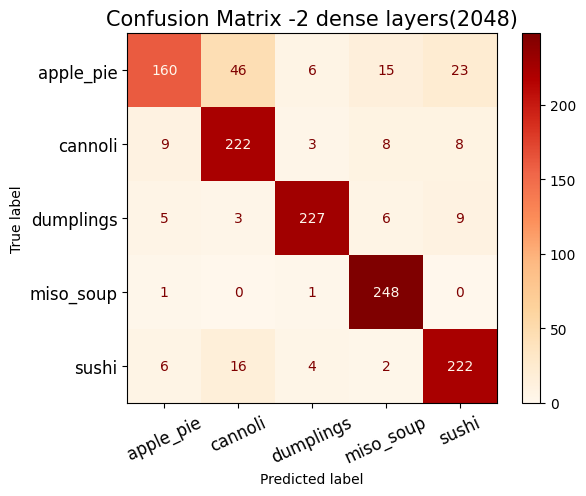

In [ ]:
%matplotlib inline
confusion_with_labels = ConfusionMatrixDisplay(confusion_1, display_labels=food_list)

confusion_with_labels.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Giving name to the plot
plt.title('Confusion Matrix -2 dense layers(2048)', fontsize=15)
plt.show()

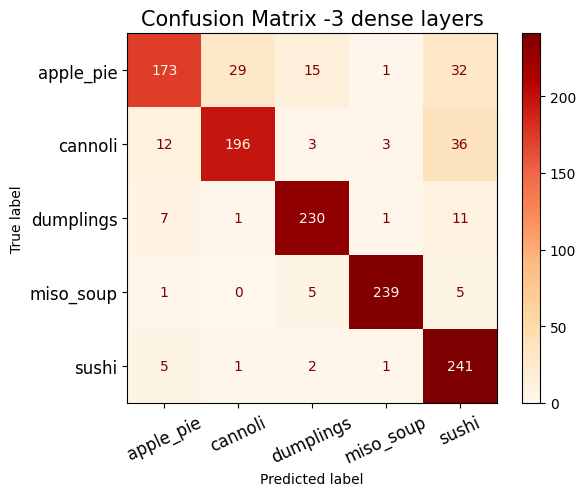

In [ ]:
%matplotlib inline
confusion_with_labels = ConfusionMatrixDisplay(confusion_2, display_labels=food_list)

confusion_with_labels.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Giving name to the plot
plt.title('Confusion Matrix -3 dense layers', fontsize=15)
plt.show()

### ROC curve
OvR

In [ ]:
from tensorflow.keras.preprocessing import image
from sklearn.metrics import RocCurveDisplay

In [ ]:
def predictByClass(class_name):

  pred_by_class= []
  true_by_class = []

  for i in os.listdir(test_dir):

    true_class = mapping[class_name]

    for j in os.listdir(os.path.join(test_dir,class_name)):

        img_ = image.load_img(os.path.join(test_dir,class_name,j), target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0)
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        pred_by_class.append(index)
        true_by_class.append(true_class)

    return (true_by_class,pred_by_class)

In [ ]:
# y_pred = model.predict(test_generator)


40/40 [==============================] - 6s 137ms/step
[0.37179512 0.5558745  0.05102551 0.00292856 0.01837629]
